In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../datas/interim/matched_edits_all.csv")

In [3]:
df.head()

,article,user,date,comment,llm_output,weaponised,ngram,df_index,row_index_matched,fg_row_index,...,clean_before,clean_after,type_of_change_extracted,category_extracted_clean,propaganda_similarity,category_extracted_propaganda_mapped,aligned_before_chunk,aligned_after_chunk,similarity,significance_extracted
0,COVID-19_pandemic_in_Ukraine_analysis,Agathoclea,2020-03-11T20:56:06Z,removed [[Category:2019–20 coronavirus outbrea...,"Changed the category from ""2019–20 coronavirus...",Not Weaponised,annexation of Crimea by,0,15,6,...,A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,rephrasing and addition of descriptive terms,Terminology Manipulation,0.418396,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...
1,History_of_Ukraine_analysis,Icey,2006-05-21T14:09:22Z,/* Further reading */ Disambiguation link repa...,Changed the reference format for Andrew Wilson...,Not Weaponised,A referendum in the,4,384,6,...,A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,rephrasing and addition of descriptive terms,Terminology Manipulation,0.418396,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...
2,History_of_Ukraine_analysis,Irpen,2006-06-06T21:00:08Z,"this whole section doesn't belong here, speara...","Removed a section titled ""Ukraine and Nuclear ...",Not Weaponised,A referendum in the,4,389,6,...,A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,rephrasing and addition of descriptive terms,Terminology Manipulation,0.418396,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...
3,History_of_Ukraine_analysis,Icey,2006-05-21T14:09:22Z,/* Further reading */ Disambiguation link repa...,Changed the reference format for Andrew Wilson...,Not Weaponised,referendum in the largely,4,384,6,...,A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,rephrasing and addition of descriptive terms,Terminology Manipulation,0.418396,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...
4,History_of_Ukraine_analysis,Irpen,2006-06-06T21:00:08Z,"this whole section doesn't belong here, speara...","Removed a section titled ""Ukraine and Nuclear ...",Not Weaponised,referendum in the largely,4,389,6,...,A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,rephrasing and addition of descriptive terms,Terminology Manipulation,0.418396,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...


In [35]:
print(df["user"].nunique(), "unique users found")
print()
print(df["user"].value_counts().head(10))  # Top users by edit count

2454 unique users found

user
LSGH                   2385
TheDraperyFalls        2118
Toddy1                 1705
Genyo                  1377
UP9                    1214
Aleksandr Grigoryev    1066
Euroserhi               923
Dbachmann               915
Vasile                  908
Irpen                   773
Name: count, dtype: int64


## Articles we are dealing with

It seems that in the 41 unique article found, none are from the full scale Russia invasion in Ukraine.

In [5]:
print(df['article'].nunique(), "unique article found") 
print(df["article"].value_counts())

41 unique article found
article
COVID-19_pandemic_in_Ukraine_analysis                              12517
History_of_Ukraine_analysis                                        11469
Crimea_analysis                                                     9137
Annexation_of_Crimea_by_the_Russian_Federation_analysis             2103
Football_in_Ukraine_analysis                                        2034
Bukovina_analysis                                                   1513
2004_Ukrainian_presidential_election_analysis                       1380
English_Civil_War_analysis                                           853
2014_pro-Russian_unrest_in_Ukraine_analysis                          726
Bessarabia_analysis                                                  671
Alexander_II_of_Russia_analysis                                      506
Christmas_in_Ukraine_analysis                                        452
History_of_Christianity_in_Ukraine_analysis                          432
Christianity_in_Rus

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

df["year"] = pd.to_datetime(df["date"], errors="coerce").dt.year

# Drop the rows without valid year or weaponised label..
df = df.dropna(subset=["year", "weaponised"])

# Ensure correct types
df["year"] = df["year"].astype(int)

# Normalizing the weaponised field because there are some capitalised and soem not --> lowercase and strip
df["weaponised"] = df["weaponised"].astype(str).str.strip().str.lower()
df["weaponised"] = df["weaponised"].replace({
    "true": "Weaponised",
    "false": "Not Weaponised",
    "unknown": "Unknown",
    "weaponised": "Weaponised",
    "not weaponised": "Not Weaponised"
})

df["weaponised"].unique()

array(['Not Weaponised', 'Weaponised', 'Unknown'], dtype=object)

In [7]:
df["is_anon"] = df["user"].str.contains(r"^\d{1,3}\.", na=False)
df['is_bot'] = df['user'].str.contains('bot', case=False, na=False)

all_users_data = {
    # Overall dataset size
    "total_edits": len(df),
    "total_unique_users": df["user"].nunique(),
    "number_unique_articles": df["article"].nunique(),

    # User type counts (unique users)
    "num_bot_users": df.loc[df["is_bot"], "user"].nunique(),
    "num_anonymous_users": df.loc[df["is_anon"], "user"].nunique(),
    "num_registered_users": df.loc[~df["is_bot"] & ~df["is_anon"], "user"].nunique(),

    # Edit counts by user type
    "num_bot_edits": int(df["is_bot"].sum()),
    "num_anonymous_edits": int(df["is_anon"].sum()),
    "num_registered_edits": int(len(df) - (df["is_bot"].sum() + df["is_anon"].sum())),

    # Weaponisation counts
    "weaponised_edits": int((df["weaponised"] == "Weaponised").sum()),
    "non_weaponised_edits": int((df["weaponised"] == "Not Weaponised").sum()),
    "unknown_weaponised_edits": int((df["weaponised"] == "Unknown").sum())
}

all_users_data

{'total_edits': 45697,
 'total_unique_users': 2454,
 'number_unique_articles': 41,
 'num_bot_users': 92,
 'num_anonymous_users': 1011,
 'num_registered_users': 1351,
 'num_bot_edits': 1376,
 'num_anonymous_edits': 8315,
 'num_registered_edits': 36006,
 'weaponised_edits': 8388,
 'non_weaponised_edits': 37278,
 'unknown_weaponised_edits': 31}

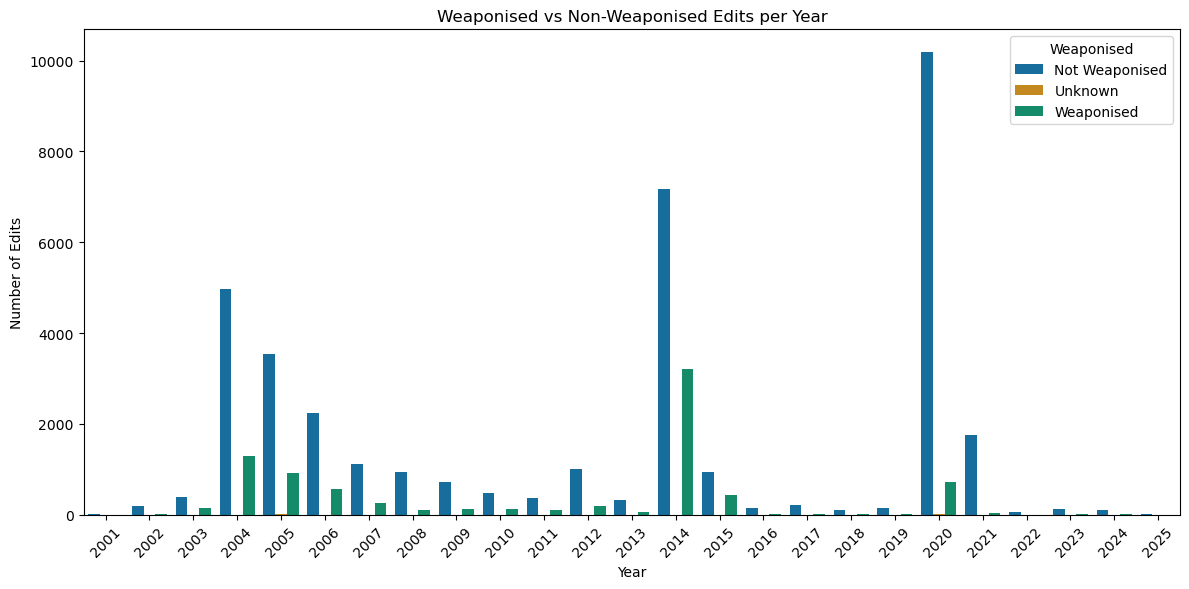

In [8]:
df_counts = df.groupby(["year", "weaponised"]).size().reset_index(name="count")

sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))
sns.barplot(data=df_counts, x="year", y="count", hue="weaponised")

plt.title("Weaponised vs Non-Weaponised Edits per Year")
plt.xlabel("Year")
plt.ylabel("Number of Edits")
plt.legend(title="Weaponised")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

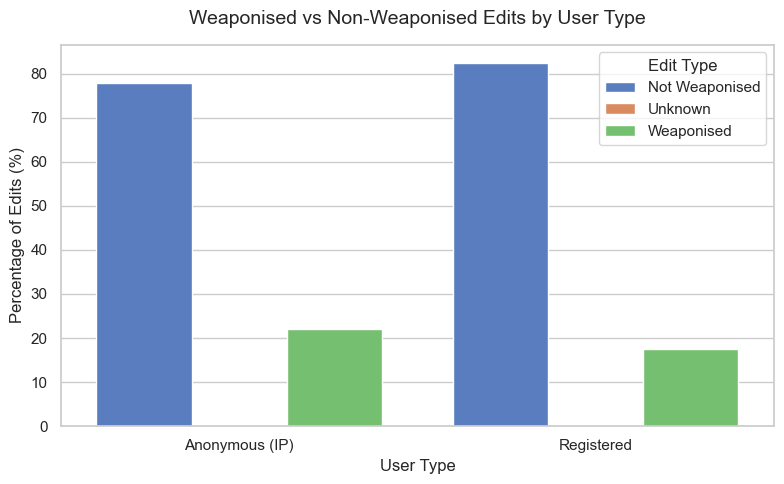

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Tag each edit with its user type
def get_user_type(row):
    
    if row["is_anon"]:
        return "Anonymous (IP)"
    else:
        return "Registered"
    
df["user_type"] = df.apply(get_user_type, axis=1)

# Count how many edits of each type are weaponised / non-weaponised
comparison = (
    df.groupby(["user_type", "weaponised"])
    .size()
    .reset_index(name="count")
)

# Compute total edits per user type and percentage of weaponised edits
totals = comparison.groupby("user_type")["count"].sum().reset_index(name="total")
comparison = comparison.merge(totals, on="user_type")
comparison["percentage"] = (comparison["count"] / comparison["total"]) * 100

# Plot weaponised vs non-weaponised ratio for each user type
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(8, 5))
sns.barplot(
    data=comparison,
    x="user_type",
    y="percentage",
    hue="weaponised"
)

plt.title("Weaponised vs Non-Weaponised Edits by User Type", fontsize=14, pad=15)
plt.xlabel("User Type", fontsize=12)
plt.ylabel("Percentage of Edits (%)", fontsize=12)
plt.legend(title="Edit Type")
plt.tight_layout()
plt.show()

In [10]:
top_users = (
    df[df["comment"].notna()]
    .groupby("user")
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
)
top_users = list(top_users)
top_users

['LSGH',
 'Toddy1',
 'TheDraperyFalls',
 'UP9',
 'Genyo',
 'Aleksandr Grigoryev',
 'Dbachmann',
 'Vasile',
 'Irpen',
 'Mzajac']

In [11]:
# jsut a subset of data for now. subset of df but with only the edits made by the top_users.
df_top = df[df["user"].isin(top_users)]

# count edits per (user, year, weaponised)
grouped = (
    df_top.groupby(["user", "year", "weaponised"])
    .size()
    .reset_index(name="count")
)
grouped

,user,year,weaponised,count
0,Aleksandr Grigoryev,2008,Not Weaponised,19
1,Aleksandr Grigoryev,2008,Weaponised,2
2,Aleksandr Grigoryev,2009,Not Weaponised,164
3,Aleksandr Grigoryev,2009,Weaponised,18
4,Aleksandr Grigoryev,2010,Not Weaponised,108
...,...,...,...,...
70,Vasile,2004,Weaponised,102
71,Vasile,2005,Not Weaponised,144
72,Vasile,2005,Weaponised,43
73,Vasile,2006,Not Weaponised,87


/Users/garambois/miniforge3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#0173b2'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/garambois/miniforge3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#0173b2'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/garambois/miniforge3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#0173b2'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/garambois/miniforge3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated a

<Figure size 1200x600 with 0 Axes>

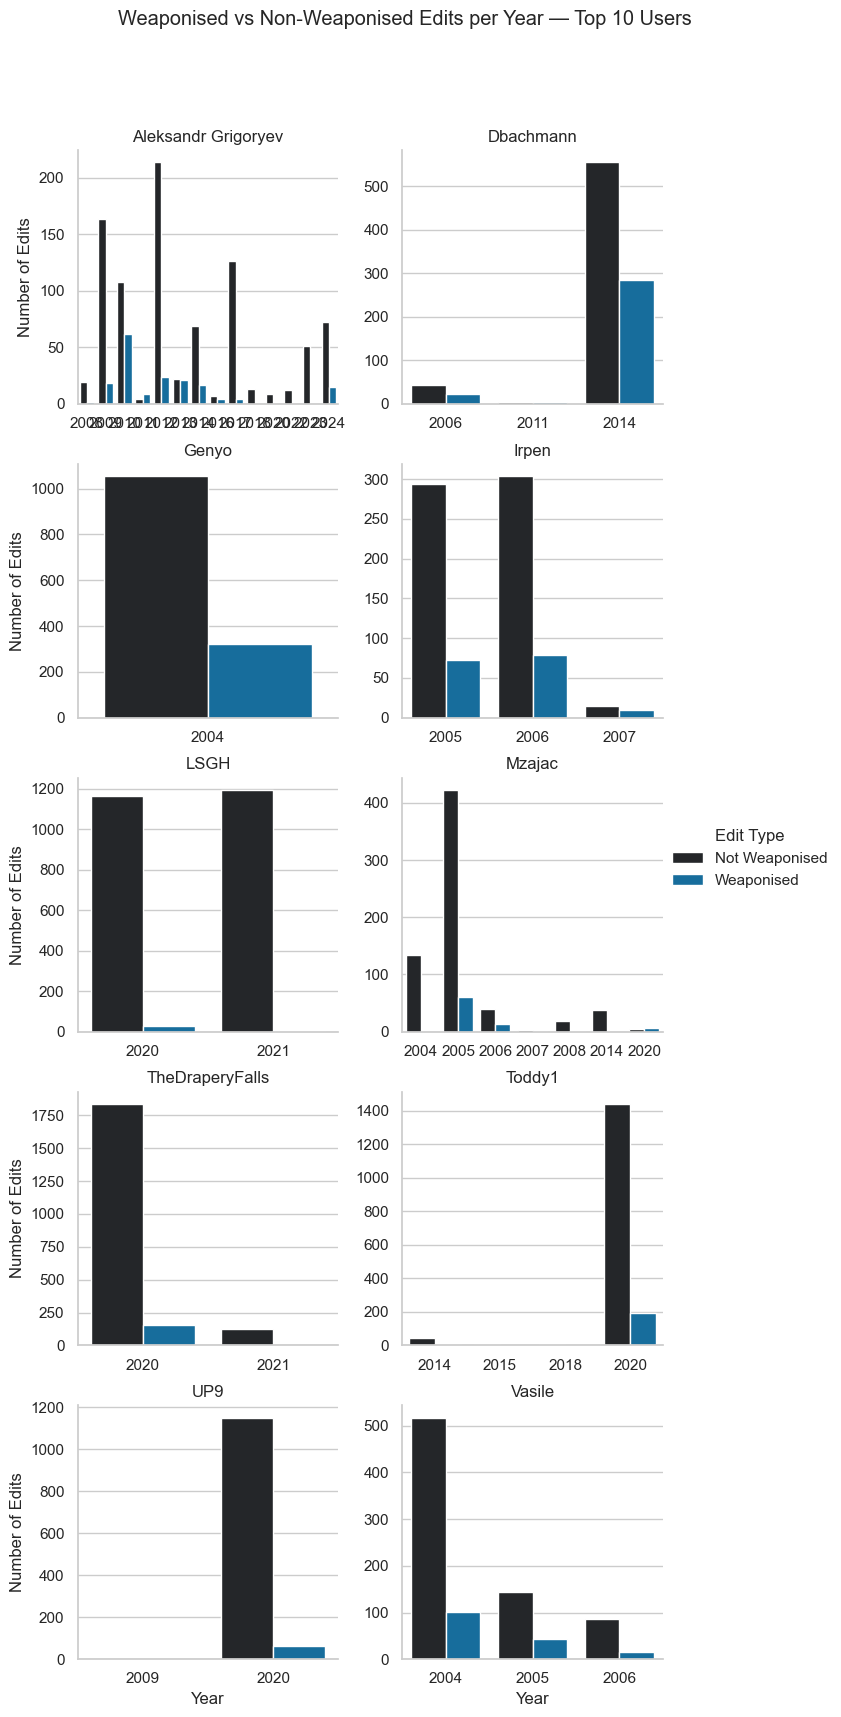

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure seaborn style
sns.set(style="whitegrid", palette="colorblind")

plt.figure(figsize=(12, 6))

# Create the barplot
g = sns.FacetGrid(grouped, col="user", col_wrap=2, height=3.5, sharey=False, sharex=False)
g.map_dataframe(sns.barplot, x="year", y="count", hue="weaponised", errorbar=None)
g.add_legend(title="Edit Type")

g.set_titles("{col_name}")
g.set_axis_labels("Year", "Number of Edits")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Weaponised vs Non-Weaponised Edits per Year — Top 10 Users")

plt.show()

# Key take aways from this first analysis

The dictionnary that recall all the primary metadatas we need is here : 
```python
{'total_edits': 45697,
 'total_unique_users': 2454,
 'number_unique_articles': 41,
 'num_bot_users': 92,
 'num_anonymous_users': 1011,
 'num_registered_users': 1351,
 'num_bot_edits': 1376,
 'num_anonymous_edits': 8315,
 'num_registered_edits': 36006,
 'weaponised_edits': 8388,
 'non_weaponised_edits': 37278,
 'unknown_weaponised_edits': 31}
```

We have the distribution over the years of eaponsing vs non weaponising edits. We have peaks of both when major geopolitical events occur like Russia Annexation of Crimea, Covid 19 or the war in Ukraine. We observe alkso a major peak during the 2005 to 2008 period. Regarding WP, the maximum editors has reched 50 000 in 2007, we can say it was the golden days of Wikipedia.

# General Info about the users

The top 10 editors are : 
```python
['LSGH',
 'Toddy1',
 'TheDraperyFalls',
 'UP9',
 'Genyo',
 'Aleksandr Grigoryev',
 'Dbachmann',
 'Vasile',
 'Irpen',
 'Mzajac']
```

> In the ```grouped``` dataframe, it says that user LSGH did some edits starting from 2020 but the graph shows that he started editing in 2004. According to the User API and User Contribution API, his first edit was in 2020 so incoherance here.

### Blockinfo and proportion regarding Ur/Ru articles

In this top 10, no user are blocked. Those users seem to be WP large contributors that are mostly not weaponsing and don't focus only on Ukraine / Russia article. The proportion shows in the df proportion can assess that. 

### Groups

| Group               | Who it includes   | Typical criteria     | Can edit semi-protected pages? | Can edit extended-protected pages? |
| ------------------- | ----------------- | -------------------- | ------------------------------ | ---------------------------------- |
| `*`                 | Anyone (even IPs) | none                 | ❌                             | ❌                                 |
| `user`              | Registered users  | account created      | ✅                             | ❌                                 |
| `autoconfirmed`     | Older + ≥10 edits | ~4 days, ≥10 edits   | ✅                             | ❌                                 |
| `extendedconfirmed` | Sustained editors | ≥30 days, ≥500 edits | ✅                             | ✅                                 |


### Gender and emailable



In [13]:
import requests
import time

HEADERS = {
    "User-Agent": "DH_Project/1.0 (https://www.epfl.ch/labs/dhlab/; maxime.garambois@epfl.ch)"
}

def get_user_info(username, max_retries=3, backoff=1.0):
    session = requests.Session()
    session.headers.update(HEADERS)
    url = "https://en.wikipedia.org/w/api.php"

    params = {
        "action": "query",
        "list": "users",
        "ususers": username,
        "usprop": "blockinfo|groups|editcount|registration|emailable|gender",
        "format": "json"
    }

    for attempt in range(max_retries):
        try:
            response = session.get(url=url, params=params, timeout=10)

            if response.status_code != 200:
                return {
                    "user": username,
                    "error": f"HTTP {response.status_code}"
                }

            try:
                data = response.json()
            except ValueError:
                return {
                    "user": username,
                    "error": "Invalid JSON response"
                }

            if "query" in data and "users" in data["query"]:
                return data["query"]["users"][0]
            else:
                return {
                    "user": username,
                    "error": "Missing 'users' in response"
                }

        except Exception as e:
            error_msg = str(e)
            time.sleep(backoff * (2 ** attempt))  # Exponential backoff

    return {
        "user": username,
        "error": f"Failed after {max_retries} attempts"
    }

In [15]:
user_metadata = [get_user_info(user) for user in top_users]

In [17]:
user_metadata[9]

{'userid': 61482,
 'name': 'Mzajac',
 'editcount': 66545,
 'registration': '2004-06-08T22:15:05Z',
 'groups': ['autoreviewer', 'extendedconfirmed', '*', 'user', 'autoconfirmed'],
 'emailable': '',
 'gender': 'unknown'}

In [18]:
user_metadata = pd.DataFrame(user_metadata)

user_metadata.to_csv("../datas/interim/all_user_profiles.csv", index=False)
user_metadata.head(10)

,userid,name,editcount,registration,groups,emailable,gender
0,38910429,LSGH,59406,2020-04-02T10:23:20Z,"[extendedconfirmed, *, user, autoconfirmed]",,unknown
1,3132940,Toddy1,52017,2006-12-30T16:29:31Z,"[autoreviewer, extendedconfirmed, reviewer, ro...",,unknown
2,15458982,TheDraperyFalls,11308,2011-10-04T07:05:08Z,"[extendedconfirmed, *, user, autoconfirmed, oa...",,male
3,9761029,UP9,390,2009-05-25T17:33:35Z,"[*, user, autoconfirmed, oathauth-twofactorauth]",,unknown
4,46962,Genyo,586,2004-02-25T17:41:03Z,"[*, user, autoconfirmed]",NaN,unknown
5,2425663,Aleksandr Grigoryev,160269,2006-10-08T02:40:18Z,"[autoreviewer, extendedconfirmed, reviewer, *,...",,male
6,86857,Dbachmann,227714,2004-07-21T10:44:35Z,"[*, user, autoconfirmed]",,unknown
7,65156,Vasile,2256,2004-05-13T21:51:57Z,"[*, user, autoconfirmed]",NaN,unknown
8,69761,Irpen,32604,2004-06-03T04:10:48Z,"[*, user, autoconfirmed]",,unknown
9,61482,Mzajac,66545,2004-06-08T22:15:05Z,"[autoreviewer, extendedconfirmed, *, user, aut...",,unknown


# Info about user's contributions

In [13]:
import requests
import json
import time
import pandas as pd
import numpy as np

HEADERS = {
    "User-Agent": "DH_Project/1.0 (https://www.epfl.ch/labs/dhlab/; maxime.garambois@epfl.ch)"
}

def get_all_user_contribs(username, max_edits=None):
    """
    Retrieve *all* contributions for a user via Wikipedia API pagination.
    Optionally limit total retrieved edits with `max_edits`.
    """
    session = requests.Session()
    session.headers.update(HEADERS)

    URL = "https://en.wikipedia.org/w/api.php"
    PARAMS = {
        "action": "query",
        "format": "json",
        "list": "usercontribs",
        "ucuser": username,
        "ucprop": "ids|title|timestamp|comment|size|flags",
        "uclimit": 500  # maximum allowed per query
    }

    all_edits = []
    cont = True
    uccontinue = None

    while cont:
        if uccontinue:
            PARAMS["uccontinue"] = uccontinue

        R = session.get(URL, params=PARAMS)
        R.raise_for_status()
        DATA = R.json()

        contribs = DATA.get("query", {}).get("usercontribs", [])
        for c in contribs:
            c["username"] = username
        all_edits.extend(contribs)

        uccontinue = DATA.get("continue", {}).get("uccontinue")
        cont = bool(uccontinue)

        # optional stopping condition
        if max_edits and len(all_edits) >= max_edits:
            all_edits = all_edits[:max_edits]
            break

        time.sleep(0.5)  # polite delay

    return all_edits


def sample_user_edits(edits, n=1000):
    """
    Take a proportional chronological sample of n edits across a user's entire edit history.
    """
    if len(edits) <= n:
        return edits

    df = pd.DataFrame(edits)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)

    # Evenly spaced indices across the full edit history
    indices = np.linspace(0, len(df) - 1, n, dtype=int)
    sampled_df = df.iloc[indices]
    return sampled_df.to_dict(orient="records")


# --- Collect proportional 1000-edit samples for each user ---
all_contribs = []

for ind, row in user_metadata.iterrows():
    username = row["name"]
    print(f"Fetching all contributions for: {username}")

    user_edits = get_all_user_contribs(username)
    print(f"  → Retrieved {len(user_edits)} total edits")

    sampled = sample_user_edits(user_edits, n=1000)
    print(f"  → Sampled {len(sampled)} proportional edits")

    all_contribs.extend(sampled)
    time.sleep(1)

# --- Convert to pandas DataFrame ---
user_contribs_df = pd.DataFrame(all_contribs)

# --- Reorder columns ---
cols = ["username", "userid", "pageid", "revid", "parentid", "ns", "title", "timestamp", "comment", "size"]
user_contribs_df = user_contribs_df.reindex(columns=[c for c in cols if c in user_contribs_df.columns])

print(f"✅ Final dataset: {len(user_contribs_df)} edits ({len(user_metadata)} users × 1000 samples each)")
display(user_contribs_df.head())

'# --- Collect proportional 1000-edit samples for each user ---\nall_contribs = []\n\nfor ind, row in user_metadata.iterrows():\n    username = row["name"]\n    print(f"Fetching all contributions for: {username}")\n\n    user_edits = get_all_user_contribs(username)\n    print(f"  → Retrieved {len(user_edits)} total edits")\n\n    sampled = sample_user_edits(user_edits, n=1000)\n    print(f"  → Sampled {len(sampled)} proportional edits")\n\n    all_contribs.extend(sampled)\n    time.sleep(1)\n\n# --- Convert to pandas DataFrame ---\nuser_contribs_df = pd.DataFrame(all_contribs)\n\n# --- Reorder columns ---\ncols = ["username", "userid", "pageid", "revid", "parentid", "ns", "title", "timestamp", "comment", "size"]\nuser_contribs_df = user_contribs_df.reindex(columns=[c for c in cols if c in user_contribs_df.columns])\n\nprint(f"✅ Final dataset: {len(user_contribs_df)} edits ({len(user_metadata)} users × 1000 samples each)")\ndisplay(user_contribs_df.head())'

In [19]:
user_contribs_df = pd.read_csv('../datas/interim/all_user_contribs_sub_n=1000.csv')

In [20]:
user_contribs_df["year"] = pd.to_datetime(user_contribs_df["timestamp"], errors="coerce").dt.year
user_contribs_df.head(5)

,username,userid,pageid,revid,parentid,ns,title,timestamp,comment,size,year
0,LSGH,38910429,1932755,948848709,946490533,0,Jōban Line,2020-04-03 11:09:13+00:00,Grammar corrections.,78899,2020.0
1,LSGH,38910429,23602357,952306385,917795596,0,National Police Hospital station,2020-04-21 15:47:15+00:00,ce,4460,2020.0
2,LSGH,38910429,7267234,952809210,949090518,0,Wangsimni station,2020-04-24 05:08:08+00:00,LSGH moved page [[Wangsimni station]] to [[Wan...,7930,2020.0
3,LSGH,38910429,14571249,952864559,941622779,0,Taereung station,2020-04-24 13:09:00+00:00,LSGH moved page [[Taereung station]] to [[Taer...,3819,2020.0
4,LSGH,38910429,23613875,953060509,953060029,0,Amsa station,2020-04-25 14:19:52+00:00,ce,2813,2020.0


In [21]:
user_contribs_title_year_df = user_contribs_df.groupby(["username", "year", "title"])

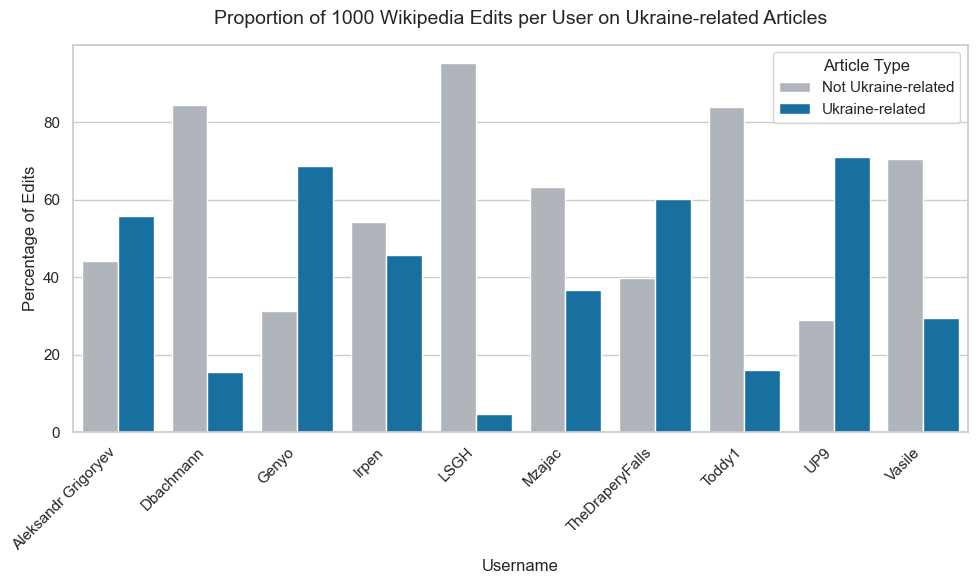

In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- STEP 1. Define Ukraine-related keyword list ---
ukraine_keywords_small = [
    "ukraine", "ukrainian", "kyiv", "kiev", "crimea", "crimean", "kuban", "donbas", "donetsk", "luhansk",
    "maidan", "yanukovych", "yushchenko", "zelenskyy", "poroshenko", "catherine", "bukovina", "bessarabia", "eastern",
    "euromaidan", "dnipro", "odessa", "sevastopol", "putin", "rus'", "russia", "russian", "moscow", "kremlin", "soviet"
]

ukraine_keywords_large = [
    # core country and people
    "ukraine", "ukrainian", "kyiv", "kiev", "crimea", "crimean", "kuban", "donbas", "donetsk", "luhansk",
    "maidan", "yanukovych", "yushchenko", "zelenskyy", "poroshenko", "catherine", "bukovina", "bessarabia",
    "eastern", "euromaidan", "dnipro", "odessa", "sevastopol", "putin", "rus'", "russia", "russian", "moscow",
    "kremlin", "soviet",

    # politics & government
    "verkhovna rada", "president", "prime minister", "parliament", "government", "cabinet", "federation",
    "referendum", "annexation", "independence", "revolution", "reforms", "corruption", "sanctions",
    "occupation", "treaty", "agreement", "ceasefire", "negotiations", "elections", "coup", "unification",

    # geography & regions
    "zaporizhzhia", "mariupol", "kharkiv", "kherson", "mykolaiv", "chernihiv", "sumy", "poltava", "vinnytsia",
    "lviv", "ivano-frankivsk", "ternopil", "lutsk", "uzhhorod", "dnipropetrovsk", "donetsk oblast",
    "luhansk oblast", "transcarpathia", "prykarpattia", "galicia", "novorossiya", "black sea", "azov sea",

    # historical references
    "kyivan rus", "tsar", "imperial", "empire", "ussr", "communist", "lenin", "stalin", "bolshevik",
    "cold war", "perestroika", "glasnost", "collapse", "partition", "catherine the great", "brezhnev",
    "chernobyl", "orange revolution", "revolution of dignity", "holodomor", "soviet union",

    # war and military
    "invasion", "occupation", "annexed", "frontline", "offensive", "defense", "army", "forces", "military",
    "russian troops", "ukrainian forces", "separatist", "rebels", "paramilitary", "nato", "eu", "un", "war",
    "conflict", "shelling", "bombing", "airstrike", "occupation forces", "mobilization", "martial law",

    # culture, identity & language
    "language", "identity", "heritage", "culture", "orthodox", "church", "patriarch", "ukrainian language",
    "russian language", "minority", "bilingual", "autonomy", "nationalism", "independence day", "flag",
    "anthem", "symbol", "national identity", "sovereignty",

    # current / modern references
    "donbas war", "russian invasion", "ukrainian front", "crimea bridge", "moskva cruiser", "ukrainian army",
    "russian army", "zelensky", "kremlin propaganda", "occupation administration", "territorial defense",
    "european union", "eu membership", "nato membership", "nato expansion", "eu sanctions", "ukraine war",
    "full-scale invasion", "special military operation", "mobilisation", "referendum in crimea",

    # other
    "gas pipeline", "north stream", "energy crisis", "grain corridor", "black sea fleet", "peace talks",
    "donetsk people's republic", "luhansk people's republic", "kyiv oblast", "liberation", "resistance",
    "occupation zone", "ukrainian refugees", "mariupol steel plant", "azovstal", "bucha", "irpin", "kharkiv offensive"
]


# --- STEP 2. Detect Ukraine-related articles ---
def is_ukraine_related(title):
    if not isinstance(title, str):
        return False
    title_lower = title.lower()
    return any(kw in title_lower for kw in ukraine_keywords_large)

user_contribs_df["ukraine_related"] = user_contribs_df["title"].apply(is_ukraine_related)

# --- STEP 3. Aggregate results per user ---
user_distribution = (
    user_contribs_df
    .groupby(["username", "ukraine_related"])
    .size()
    .reset_index(name="count")
)

# Convert to percentages
user_distribution["percentage"] = (
    user_distribution.groupby("username")["count"].transform(lambda x: 100 * x / x.sum())
)

# --- STEP 4. Plot distribution ---
sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})

# Define a clear color palette (blue = Ukraine-related, grey = not related)
palette = {True: "#0077b6", False: "#adb5bd"}

ax = sns.barplot(
    data=user_distribution,
    x="username",
    y="percentage",
    hue="ukraine_related",
    palette=palette
)

plt.title("Proportion of 1000 Wikipedia Edits per User on Ukraine-related Articles", fontsize=14, pad=15)
plt.xlabel("Username", fontsize=12)
plt.ylabel("Percentage of Edits", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Fix legend: ensure correct order and labels
handles, labels = ax.get_legend_handles_labels()
new_labels = ["Ukraine-related", "Not Ukraine-related"] if labels[0] == "True" else ["Not Ukraine-related", "Ukraine-related"]
plt.legend(handles=handles, labels=new_labels, title="Article Type", loc="upper right")

plt.tight_layout()
plt.show()

In [111]:
import requests
import json
import time
import pandas as pd
import numpy as np

HEADERS = {
    "User-Agent": "DH_Project/1.0 (https://www.epfl.ch/labs/dhlab/; maxime.garambois@epfl.ch)"
}

def get_all_user_contribs(username, max_edits=None):
    """
    Retrieve *all* contributions for a user via Wikipedia API pagination.
    Optionally limit total retrieved edits with `max_edits`.
    """
    session = requests.Session()
    session.headers.update(HEADERS)

    URL = "https://en.wikipedia.org/w/api.php"
    PARAMS = {
        "action": "query",
        "format": "json",
        "list": "usercontribs",
        "ucuser": username,
        "ucprop": "ids|title|timestamp|comment|size|flags",
        "uclimit": 500  # maximum allowed per query
    }

    all_edits = []
    cont = True
    uccontinue = None

    while cont:
        if uccontinue:
            PARAMS["uccontinue"] = uccontinue

        R = session.get(URL, params=PARAMS)
        R.raise_for_status()
        DATA = R.json()

        contribs = DATA.get("query", {}).get("usercontribs", [])
        for c in contribs:
            c["username"] = username
        all_edits.extend(contribs)

        uccontinue = DATA.get("continue", {}).get("uccontinue")
        cont = bool(uccontinue)

        # optional stopping condition
        if max_edits and len(all_edits) >= max_edits:
            all_edits = all_edits[:max_edits]
            break

        time.sleep(0.5)  # polite delay

    return all_edits

# --- Collect proportional 1000-edit samples for each user ---
all_contribs_full = []

for ind, row in user_metadata.iterrows():
    username = row["name"]
    print(f"Fetching all contributions for: {username}")

    user_edits = get_all_user_contribs(username)
    print(f"  → Retrieved {len(user_edits)} total edits")

    all_contribs_full.extend(user_edits)
    time.sleep(1)

# --- Convert to pandas DataFrame ---
user_contribs_df = pd.DataFrame(all_contribs_full)

# --- Reorder columns ---
cols = ["username", "userid", "pageid", "revid", "parentid", "ns", "title", "timestamp", "comment", "size"]
user_contribs_df = user_contribs_df.reindex(columns=[c for c in cols if c in user_contribs_df.columns])

print(f"✅ Final dataset: {len(user_contribs_df)} edits ({len(user_metadata)} users × 1000 samples each)")
display(user_contribs_df.head())

Fetching all contributions for: LSGH
  → Retrieved 59468 total edits
Fetching all contributions for: Toddy1
  → Retrieved 51357 total edits
Fetching all contributions for: TheDraperyFalls
  → Retrieved 11159 total edits
Fetching all contributions for: UP9
  → Retrieved 391 total edits
Fetching all contributions for: Genyo
  → Retrieved 573 total edits
Fetching all contributions for: Aleksandr Grigoryev
  → Retrieved 158366 total edits
Fetching all contributions for: Dbachmann
  → Retrieved 225145 total edits
Fetching all contributions for: Vasile
  → Retrieved 2234 total edits
Fetching all contributions for: Irpen
  → Retrieved 31012 total edits
Fetching all contributions for: Mzajac
  → Retrieved 65117 total edits
✅ Final dataset: 604822 edits (10 users × 1000 samples each)


,username,userid,pageid,revid,parentid,ns,title,timestamp,comment,size
0,LSGH,38910429,63260687,1075136185,1074964872,0,COVID-19 pandemic in Bahrain,2022-03-04T04:03:16Z,Updating number of cases in infobox,64532
1,LSGH,38910429,63339598,1075135994,1074964830,10,Template:COVID-19 pandemic data/South Africa m...,2022-03-04T04:01:40Z,Adding number of cases for March 03,23607
2,LSGH,38910429,63281706,1075022468,1074969215,0,COVID-19 pandemic in Latvia,2022-03-03T13:19:02Z,Updating number of cases in infobox,153418
3,LSGH,38910429,63353757,1075022344,1074969128,10,Template:COVID-19 pandemic data/Latvia medical...,2022-03-03T13:18:11Z,Adding number of cases for March 03,19318
4,LSGH,38910429,63262762,1075022265,1074414768,0,COVID-19 pandemic in Andorra,2022-03-03T13:17:26Z,Updating number of cases in infobox,35796


In [22]:
all_user_contribs_df = pd.read_csv('../datas/interim/all_user_contribs.csv')
all_user_contribs_df["year"] = pd.to_datetime(all_user_contribs_df["timestamp"], errors="coerce").dt.year
all_user_contribs_df.shape

(604822, 12)

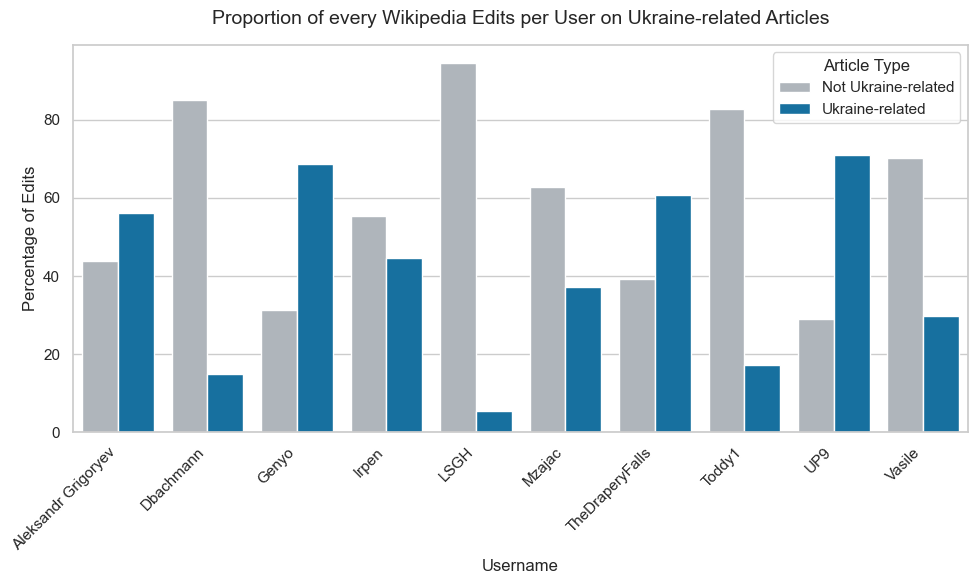

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- STEP 1. Define Ukraine-related keyword list ---
ukraine_keywords_small = [
    "ukraine", "ukrainian", "kyiv", "kiev", "crimea", "crimean", "kuban", "donbas", "donetsk", "luhansk",
    "maidan", "yanukovych", "yushchenko", "zelenskyy", "poroshenko", "catherine", "bukovina", "bessarabia", "eastern",
    "euromaidan", "dnipro", "odessa", "sevastopol", "putin", "rus'", "russia", "russian", "moscow", "kremlin", "soviet"
]

ukraine_keywords_large = [
    # core country and people
    "ukraine", "ukrainian", "kyiv", "kiev", "crimea", "crimean", "kuban", "donbas", "donetsk", "luhansk",
    "maidan", "yanukovych", "yushchenko", "zelenskyy", "poroshenko", "catherine", "bukovina", "bessarabia",
    "eastern", "euromaidan", "dnipro", "odessa", "sevastopol", "putin", "rus'", "russia", "russian", "moscow",
    "kremlin", "soviet",

    # politics & government
    "verkhovna rada", "president", "prime minister", "parliament", "government", "cabinet", "federation",
    "referendum", "annexation", "independence", "revolution", "reforms", "corruption", "sanctions",
    "occupation", "treaty", "agreement", "ceasefire", "negotiations", "elections", "coup", "unification",

    # geography & regions
    "zaporizhzhia", "mariupol", "kharkiv", "kherson", "mykolaiv", "chernihiv", "sumy", "poltava", "vinnytsia",
    "lviv", "ivano-frankivsk", "ternopil", "lutsk", "uzhhorod", "dnipropetrovsk", "donetsk oblast",
    "luhansk oblast", "transcarpathia", "prykarpattia", "galicia", "novorossiya", "black sea", "azov sea",

    # historical references
    "kyivan rus", "tsar", "imperial", "empire", "ussr", "communist", "lenin", "stalin", "bolshevik",
    "cold war", "perestroika", "glasnost", "collapse", "partition", "catherine the great", "brezhnev",
    "chernobyl", "orange revolution", "revolution of dignity", "holodomor", "soviet union",

    # war and military
    "invasion", "occupation", "annexed", "frontline", "offensive", "defense", "army", "forces", "military",
    "russian troops", "ukrainian forces", "separatist", "rebels", "paramilitary", "nato", "eu", "un", "war",
    "conflict", "shelling", "bombing", "airstrike", "occupation forces", "mobilization", "martial law",

    # culture, identity & language
    "language", "identity", "heritage", "culture", "orthodox", "church", "patriarch", "ukrainian language",
    "russian language", "minority", "bilingual", "autonomy", "nationalism", "independence day", "flag",
    "anthem", "symbol", "national identity", "sovereignty",

    # current / modern references
    "donbas war", "russian invasion", "ukrainian front", "crimea bridge", "moskva cruiser", "ukrainian army",
    "russian army", "zelensky", "kremlin propaganda", "occupation administration", "territorial defense",
    "european union", "eu membership", "nato membership", "nato expansion", "eu sanctions", "ukraine war",
    "full-scale invasion", "special military operation", "mobilisation", "referendum in crimea",

    # other
    "gas pipeline", "north stream", "energy crisis", "grain corridor", "black sea fleet", "peace talks",
    "donetsk people's republic", "luhansk people's republic", "kyiv oblast", "liberation", "resistance",
    "occupation zone", "ukrainian refugees", "mariupol steel plant", "azovstal", "bucha", "irpin", "kharkiv offensive"
]


# --- STEP 2. Detect Ukraine-related articles ---
def is_ukraine_related(title):
    if not isinstance(title, str):
        return False
    title_lower = title.lower()
    return any(kw in title_lower for kw in ukraine_keywords_large)

all_user_contribs_df["ukraine_related"] = all_user_contribs_df["title"].apply(is_ukraine_related)

# --- STEP 3. Aggregate results per user ---
user_distribution = (
    all_user_contribs_df
    .groupby(["username", "ukraine_related"])
    .size()
    .reset_index(name="count")
)

# Convert to percentages
user_distribution["percentage"] = (
    user_distribution.groupby("username")["count"].transform(lambda x: 100 * x / x.sum())
)

# --- STEP 4. Plot distribution ---
sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})

# Define a clear color palette (blue = Ukraine-related, grey = not related)
palette = {True: "#0077b6", False: "#adb5bd"}

ax = sns.barplot(
    data=user_distribution,
    x="username",
    y="percentage",
    hue="ukraine_related",
    palette=palette
)

plt.title("Proportion of every Wikipedia Edits per User on Ukraine-related Articles", fontsize=14, pad=15)
plt.xlabel("Username", fontsize=12)
plt.ylabel("Percentage of Edits", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Fix legend: ensure correct order and labels
handles, labels = ax.get_legend_handles_labels()
new_labels = ["Ukraine-related", "Not Ukraine-related"] if labels[0] == "True" else ["Not Ukraine-related", "Ukraine-related"]
plt.legend(handles=handles, labels=new_labels, title="Article Type", loc="upper right")

plt.tight_layout()
plt.show()

In [18]:
#!/usr/bin/env python3
"""
ip_locations_average_with_proxy_map.py

- Use ip-api.com batch endpoint to geolocate IP addresses (max 100 per request)
- Add proxy info (True/False)
- Compute spherical geographic centroid
- Save results to CSV
- Generate interactive Folium map of all IP locations

Requirements:
    pip install requests pandas folium
"""

import requests
import time
import math
import pandas as pd
import folium
from typing import List, Dict, Any

BATCH_URL = "http://ip-api.com/batch"   # free tier, HTTP only
HEADERS = {
    "User-Agent": "DH_Project/1.0 (https://www.epfl.ch/labs/dhlab/; maxime.garambois@epfl.ch)",
    "Content-Type": "application/json"
}

# --- Add proxy flag in fields ---
FIELDS = "status,query,lat,lon,city,country,proxy,message"

def chunked(iterable, n):
    for i in range(0, len(iterable), n):
        yield iterable[i : i + n]

def query_ip_batch(ip_list: List[str]) -> List[Dict[str, Any]]:
    params = {"fields": FIELDS}
    resp = requests.post(BATCH_URL, json=ip_list, params=params, headers=HEADERS, timeout=30)
    resp.raise_for_status()

    # Respect rate limits if provided
    xr = resp.headers.get("X-Rl")
    xt = resp.headers.get("X-Ttl")
    if xr is not None:
        try:
            xr_num = int(xr)
            xt_num = int(xt) if xt is not None else None
            if xr_num <= 0 and xt_num:
                print(f"[rate-limit] X-Rl=0, sleeping {xt_num}s")
                time.sleep(xt_num + 1)
        except Exception:
            pass
    return resp.json()

def geographic_centroid(coords: List[Dict[str, float]]) -> Dict[str, float]:
    if not coords:
        return {"lat": None, "lon": None}
    x = y = z = 0.0
    count = 0
    for c in coords:
        lat, lon = c.get("lat"), c.get("lon")
        if lat is None or lon is None:
            continue
        lat_r, lon_r = math.radians(lat), math.radians(lon)
        x += math.cos(lat_r) * math.cos(lon_r)
        y += math.cos(lat_r) * math.sin(lon_r)
        z += math.sin(lat_r)
        count += 1
    if count == 0:
        return {"lat": None, "lon": None}
    x /= count
    y /= count
    z /= count
    hyp = math.sqrt(x * x + y * y)
    return {
        "lat": math.degrees(math.atan2(z, hyp)),
        "lon": math.degrees(math.atan2(y, x))
    }

def main(ip_addresses: List[str], output_csv: str = "ip_api_results.csv"):
    unique_ips = list(dict.fromkeys(ip_addresses))
    print(f"Total unique IPs to query: {len(unique_ips)}")

    all_results = []
    for batch_idx, batch in enumerate(chunked(unique_ips, 100), start=1):
        print(f"Querying batch {batch_idx}: {len(batch)} IPs")
        try:
            results = query_ip_batch(batch)
        except requests.HTTPError as e:
            print(f"HTTP error for batch {batch_idx}: {e}")
            raise
        all_results.extend(results)
        time.sleep(4.2)

    df = pd.DataFrame(all_results)
    df.to_csv(output_csv, index=False, encoding="utf-8")
    print(f"✅ Saved raw results to {output_csv}")

    success_df = df[df["status"] == "success"].copy()
    coords = success_df[["lat", "lon"]].dropna().to_dict(orient="records")
    centroid = geographic_centroid(coords)
    print(f"🌍 Geographic centroid: {centroid}")

    # --- Generate Folium Map ---
    print("🗺️  Generating map...")
    if coords:
        m = folium.Map(location=[centroid["lat"], centroid["lon"]], zoom_start=3, tiles="cartodb positron")

        for _, row in success_df.iterrows():
            lat, lon = row["lat"], row["lon"]
            proxy = row.get("proxy", False)
            color = "red" if proxy else "blue"
            tooltip = f"IP: {row['query']}<br>{row['city']}, {row['country']}<br>Proxy: {proxy}"
            folium.CircleMarker(
                location=[lat, lon],
                radius=5,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                tooltip=tooltip
            ).add_to(m)

        # Add centroid marker
        folium.Marker(
            location=[centroid["lat"], centroid["lon"]],
            icon=folium.Icon(color="green", icon="crosshairs"),
            tooltip="Geographic Centroid"
        ).add_to(m)

        m.save("ip_locations_map.html")
        print("✅ Saved interactive map as ip_locations_map.html")

    else:
        print("⚠️ No successful geolocations to map.")

    return df, centroid

# --- Example usage ---
if __name__ == "__main__":
    df, centroid = main(res)

Total unique IPs to query: 275
Querying batch 1: 100 IPs
Querying batch 2: 100 IPs
Querying batch 3: 75 IPs
✅ Saved raw results to ip_api_results.csv
🌍 Geographic centroid: {'lat': 63.640697467487676, 'lon': -38.91083014214465}
🗺️  Generating map...
✅ Saved interactive map as ip_locations_map.html


In [24]:
from collections import OrderedDict

ip_adresses = []
df["is_anon"] = df["user"].str.contains(r"^\d{1,3}\.", na=False)
for ind, row in df.iterrows():
    if row['is_anon'] == True and row['weaponised'] == 'Weaponised':
        ip_adresses.append(row['user'])

ip_adresses
res = list(OrderedDict.fromkeys(ip_adresses))
print(res)

['141.149.187.165', '94.178.235.125', '213.78.80.38', '172.202.173.230', '82.144.200.5', '134.176.66.174', '194.74.176.98', '72.161.211.139', '61.102.45.248', '207.112.30.60', '209.244.188.196', '210.13.96.76', '77.122.72.181', '174.3.111.148', '91.90.13.169', '98.71.105.94', '134.176.204.181', '89.235.213.96', '67.193.142.54', '95.14.70.121', '174.89.174.215', '50.198.120.29', '203.36.44.11', '83.137.81.58', '71.240.66.196', '24.185.36.227', '67.134.174.54', '173.206.225.216', '68.32.191.205', '99.90.196.227', '24.126.41.116', '83.249.75.80', '24.98.242.7', '67.161.165.120', '82.131.22.177', '193.231.183.45', '128.205.248.234', '81.196.254.131', '172.215.166.53', '216.47.142.240', '130.238.65.18', '75.175.96.234', '41.196.55.100', '212.137.36.230', '216.241.207.54', '168.216.133.7', '24.90.103.25', '24.207.56.248', '71.198.232.146', '93.73.13.209', '82.82.129.206', '83.16.78.126', '78.61.34.186', '5.20.209.160', '85.26.183.193', '74.33.74.198', '46.162.242.242', '64.134.237.5', '194.1

In [27]:
print(f'all the IP adresses gathered in matched_all_edits.csv is : {len(ip_adresses)} but # of unique IP is {len(res)}')

all the IP adresses gathered in matched_all_edits.csv is : 1834 but # of unique IP is 275


/Users/garambois/miniforge3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#0173b2'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/garambois/miniforge3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#0173b2'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/garambois/miniforge3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#0173b2'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/garambois/miniforge3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated a

<Figure size 1200x600 with 0 Axes>

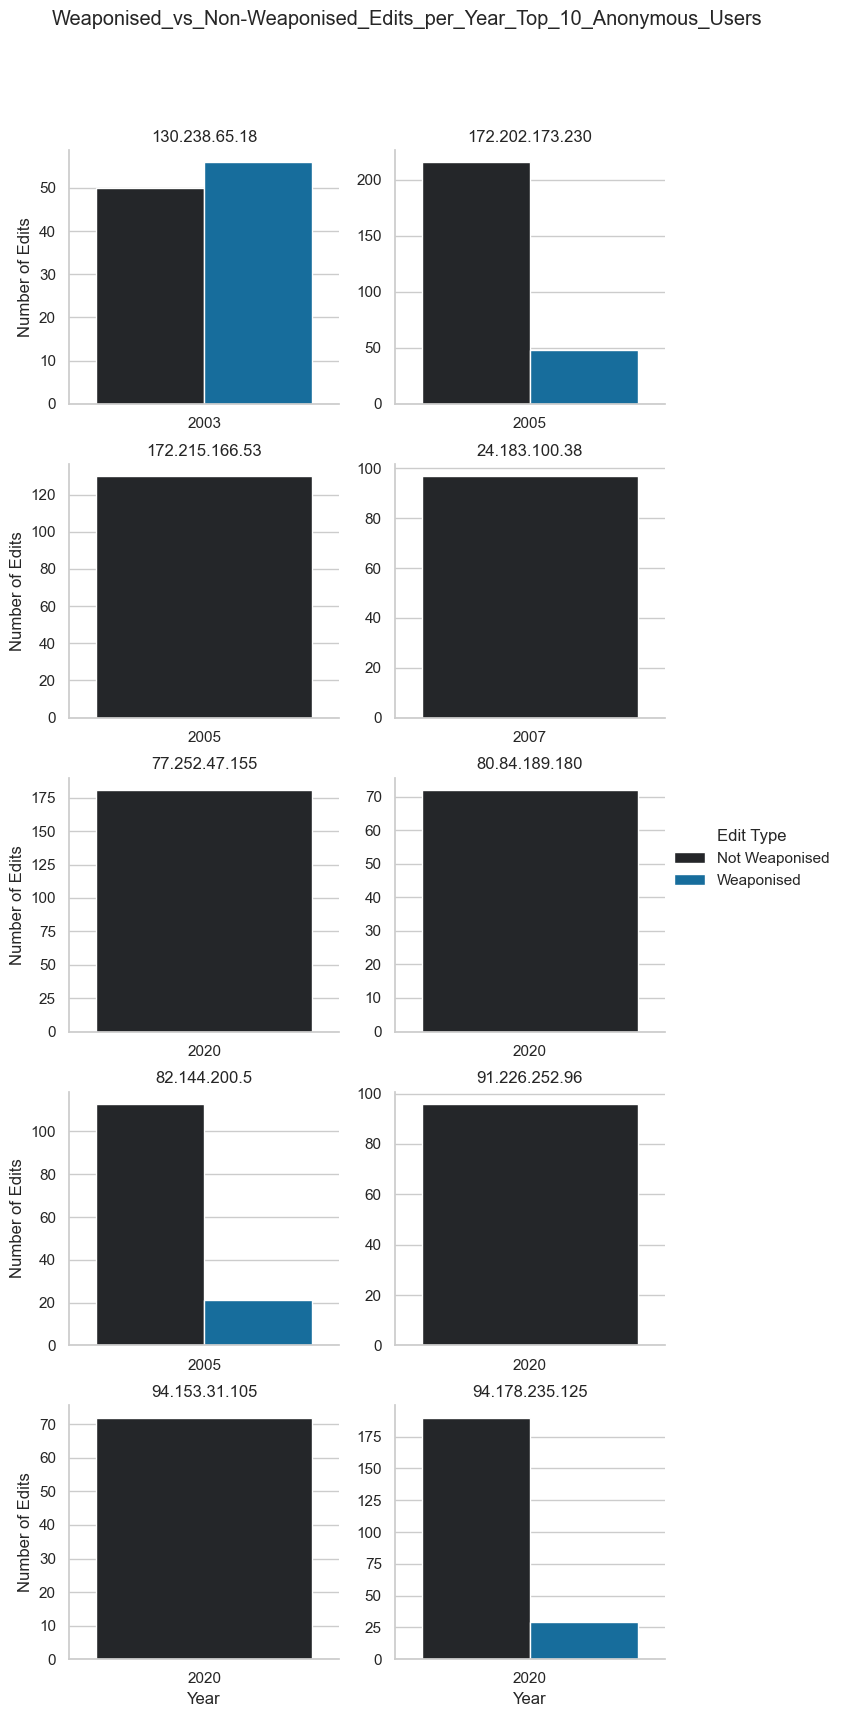

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only anonymous (IP address) users
df_ip = df[df["is_anon"] == True]

# Find the top 10 IP addresses by number of edits
ip_top_users = (
    df_ip["user"]
    .value_counts()
    .head(10)
    .index
    .tolist()
)

# Subset dataframe to only those top 10 IP users
df_ip_top = df_ip[df_ip["user"].isin(ip_top_users)]

# Group edits by user, year, and weaponisation
ip_grouped = (
    df_ip_top.groupby(["user", "year", "weaponised"])
    .size()
    .reset_index(name="count")
)

# Ensure seaborn style
sns.set(style="whitegrid", palette="colorblind")

plt.figure(figsize=(12, 6))

# Create the barplot
g = sns.FacetGrid(ip_grouped, col="user", col_wrap=2, height=3.5, sharey=False, sharex=False)
g.map_dataframe(sns.barplot, x="year", y="count", hue="weaponised", errorbar=None)
g.add_legend(title="Edit Type")

g.set_titles("{col_name}")
g.set_axis_labels("Year", "Number of Edits")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Weaponised_vs_Non-Weaponised_Edits_per_Year_Top_10_Anonymous_Users")

plt.show()

## New section

The goal of this next section is to see the magnitude of the edits between only weaponsing edits by registered user vs weaponsing edits done by IP user. In order to do that, we will compute the len(initial_version) - len(changed_version) to see if weap edits are more concise than non weap edits and if IP adress are more concise than registered edits.

In [47]:
df_registered = df[df['user_type'] == 'Registered']
df_registered_weap = df_registered[df_registered['weaponised'] == 'Weaponised']
df_registered_weap

,article,user,date,comment,llm_output,weaponised,ngram,df_index,row_index_matched,fg_row_index,...,propaganda_similarity,category_extracted_propaganda_mapped,aligned_before_chunk,aligned_after_chunk,similarity,significance_extracted,year,is_anon,is_bot,user_type
12,History_of_Ukraine_analysis,Irpen,2006-06-14T15:11:52Z,"read Holodomor, numbers are discussed",The change made in this revision is the additi...,Weaponised,in the largely ethnic,4,401,6,...,0.418396,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...,2006,False,False,Registered
32,History_of_Ukraine_analysis,Irpen,2006-06-14T15:11:52Z,"read Holodomor, numbers are discussed",The change made in this revision is the additi...,Weaponised,the largely ethnic Russian,4,401,6,...,0.418396,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...,2006,False,False,Registered
51,COVID-19_pandemic_in_Ukraine_analysis,Perep80,2020-03-29T00:27:43Z,Updates to table of daily cases,"Described change: Added new columns for ""Death...",Weaponised,annexation of Crimea by,4,303,6,...,0.418396,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...,2020,False,False,Registered
77,COVID-19_pandemic_in_Ukraine_analysis,UP9,2020-04-07T16:56:45Z,Added 'so-called' and 'annexed',The change made is the addition of the phrases...,Weaponised,annexation of Crimea by,4,399,6,...,0.418396,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...,2020,False,False,Registered
86,COVID-19_pandemic_in_Ukraine_analysis,Adûnâi,2020-04-10T03:26:29Z,"Wording corrected, grammar corrected (definite...",The change made was a rephrasing of terms rela...,Weaponised,annexation of Crimea by,4,426,6,...,0.418396,"Obfuscation, intentional vagueness",A referendum in the largely ethnic Russian Ukr...,A referendum in the largely ethnic Russian Ukr...,0.925267,The use of terms like 'bloodless' and 'bloody ...,2020,False,False,Registered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45615,COVID-19_pandemic_in_Ukraine_analysis,TheDraperyFalls,2020-05-28T07:47:34Z,/* Cases by region */,The change involves updating numerical values ...,Weaponised,the Donetsk and Luhansk,46,650,798,...,0.418396,"Obfuscation, intentional vagueness","On 26 February 2014, Russian-speaking gunmen s...","\n \n During the Crimean crisis, demonstration...",0.562791,The addition of the phrase 'in what has been t...,2020,False,False,Registered
45624,COVID-19_pandemic_in_Ukraine_analysis,TheDraperyFalls,2020-07-02T08:58:16Z,/* Cases by region */ regional caseload updated,The change made in this revision is an update ...,Weaponised,the Donetsk and Luhansk,46,765,798,...,0.418396,"Obfuscation, intentional vagueness","On 26 February 2014, Russian-speaking gunmen s...","\n \n During the Crimean crisis, demonstration...",0.562791,The addition of the phrase 'in what has been t...,2020,False,False,Registered
45638,COVID-19_pandemic_in_Ukraine_analysis,LSGH,2021-04-28T05:29:44Z,Updating number of cases in infobox,"Change: Updated the number of confirmed cases,...",Weaponised,the Donetsk and Luhansk,46,1169,798,...,0.418396,"Obfuscation, intentional vagueness","On 26 February 2014, Russian-speaking gunmen s...","\n \n During the Crimean crisis, demonstration...",0.562791,The addition of the phrase 'in what has been t...,2021,False,False,Registered
45663,COVID-19_pandemic_in_Ukraine_analysis,LSGH,2021-04-28T05:29:44Z,Updating number of cases in infobox,"Change: Updated the

In [44]:
df_ip = df[df["is_anon"] == True]
len(df_ip)

8315